In [2]:
from dask.distributed import Client
import numpy as np
import dask.array as da
from dask import delayed


client = Client(n_workers=6)
client

from utils.xarray_functions import add_time
import os 
import xarray as xr
from utils.xarray_functions import add_time, compute_radiance
from utils.xarray_functions import compute_ndvi
from utils.function_clns import config


### SEVIRI 
chunks = {"time":-1, "lat":25, "lon":25}
filename = "ndvi_full_image.zarr"
ds_ndvi_915 = xr.open_zarr(os.path.join(config["NDVI"]["ndvi_path"],filename), chunks=chunks)

def preprocess(ds):
    ds = add_time(ds)
    return ds

# path1 = "/media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/09_30"
# files = [os.path.join(path1, file) for file in os.listdir(path1) if file.endswith(".nc")][:4]
# ds_cloud930 = xr.open_mfdataset(files, preprocess=preprocess)

path2 = "/media/BIFROST/N2/Riccardo/MSG/cloudmask/processed_clouds/09_15"
files = [os.path.join(path2, file) for file in os.listdir(path2) if file.endswith(".nc")]
ds_cloud915 = xr.open_mfdataset(files, preprocess=preprocess, engine='netcdf4', parallel=True)

2024-03-07 11:32:14,834 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c38h74m0', purging
2024-03-07 11:32:14,835 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-nqc89h9u', purging
2024-03-07 11:32:14,835 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-1q8_phjk', purging
2024-03-07 11:32:14,835 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ufnig_62', purging
2024-03-07 11:32:14,835 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y9tr5exq', purging
2024-03-07 11:32:14,836 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-3v7kkx41', purging
2024-03-07 11:32:14,836 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ze7hfwk7', purging

In [3]:
from vegetation.preprocessing.ndvi_prep import apply_seviri_cloudmask
ds = apply_seviri_cloudmask(ds_ndvi_915, ds_cloud915)

from vegetation.preprocessing.ndvi_prep import XarrayWS
from dask.diagnostics import ProgressBar

ws_ds = XarrayWS(ds.chunk(chunks={"time":-1, "lat":50, "lon":50}))
with ProgressBar():
    ds_clean = ws_ds.apply_ws2doptvp(variable="ndvi", p=0.99, lambda_max=4)

/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/abc.py:85: FutureWarning: xarray subclass XarrayWS should explicitly define __slots__
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 624
  result = blockwise(
/home/woden/anaconda3/envs/ric_gis_py39/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 624
  result = blockwise(


INFO:distributed.core:Event loop was unresponsive in Nanny for 3.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 5.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 5.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

In [5]:
client.close()

In [42]:
import xarray_beam as xbeam 
import xarray
import apache_beam as beam
from dask.diagnostics import ProgressBar

ds_beam = xbeam.Dataset.from_xarray(ds, chunks={"time":-1, "lat":50, "lon":50})

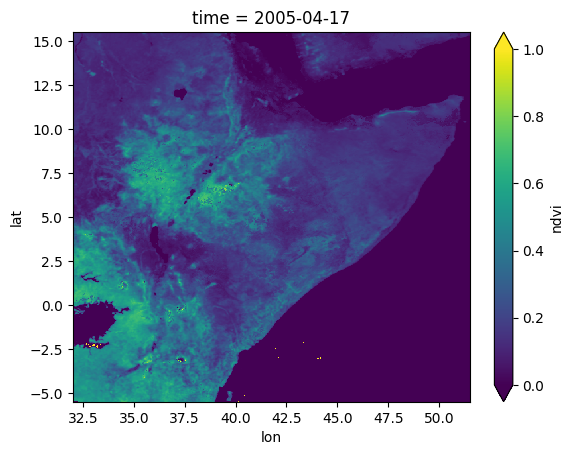

In [50]:
ds_clean.ndvi.isel(time=100).plot(vmax = 1, vmin=0)

In [56]:
mask_error = xr.where((ds_clean["ndvi"]<-1)|(ds_clean["ndvi"]>1),1,0)
mask_err = (mask_error.sum(["time"])/mask_error.count(["time"]))

In [79]:
# Define your condition
condition = mask_err > 0.2

# Use boolean indexing to filter lat and lon combinations that meet the condition
lat_lon_combinations = ds_clean.where(condition, drop=True)

# Access the lat and lon values of the filtered combinations
filtered_lat = lat_lon_combinations['lat'].values
filtered_lon = lat_lon_combinations['lon'].values

import numpy as np
lat_indices, lon_indices = np.where(condition)

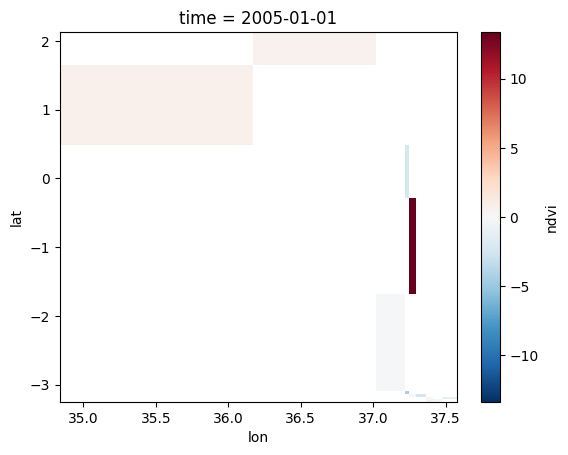

In [91]:
lat_lon_combinations.ndvi.isel(time=0).plot()

In [106]:
from modape.whittaker import ws2doptv, ws2d, ws2doptvp
from array import array

y = ds.ndvi.sel(lat=1, lon =35.5, method="nearest").chunk({"time":-1}).values
y_corr = np.where(np.isnan(y), 0, y) 
w = np.where(np.isnan(y), 0, 1)

p = 0.99 
lambda_min=-2
lambda_max = 4

w_corr = w.astype(np.double)
y_corr_db = y_corr.astype(np.double)

z, sopt = ws2doptvp(y_corr_db, w_corr, 
                    array("d", np.arange(lambda_min, lambda_max, 0.2).round(2)), 
                    p=p)
z_arr =  np.array(z, dtype=np.float32)

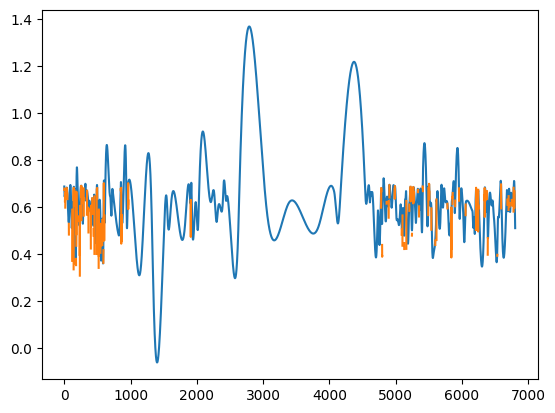

In [115]:
import matplotlib.pyplot as plt
plt.plot(z_arr)
plt.plot(y)

In [105]:
#lat_lon_combinations.ndvi.sel(lat=-1, lon =37.25, method="nearest").plot()


<xarray.DataArray 'ndvi' (time: 6805)> Size: 27kB
dask.array<rechunk-merge, shape=(6805,), dtype=float32, chunksize=(6805,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 8B 1.005
    lon      float64 8B 35.51
  * time     (time) datetime64[ns] 54kB 2005-01-01 2005-01-02 ... 2023-12-31

In [4]:
import zarr

compressor = zarr.Blosc(cname="zstd", clevel=3, shuffle=2)
# encodings
enc = {x: {"compressor": compressor} for x in ds}

filename = "ndvi_full_image.zarr"
# encoding = {'zlib': True, "complevel":4}
# compression = {"ndvi" :encoding, "channel_1":encoding, "channel_2": encoding}
from utils.function_clns import config
from dask.diagnostics import ProgressBar

with ProgressBar():
    ndvi.to_zarr(os.path.join(config["NDVI"]["ndvi_path"], filename),
             encoding=enc)

[                                        ] | 0% Completed | 333.62 ss

IOStream.flush timed out


[########################################] | 100% Completed | 6hr 42m


In [ ]:
from vegetation.preprocessing.ndvi_clean import XarrayWS

ws = XarrayWS(on_disk.chunk({"time":-1, "lat":50, "lon":50}))
data = ws.apply_ws2doptvp("ndvi", p=0.99, lambda_max=4)

In [5]:
mean_ndvi = on_disk["ndvi"].mean(["lat","lon"])

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_ndvi.plot()

In [ ]:
import os
from utils.function_clns import config, prepare, subsetting_pipeline
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

dataset = prepare(subsetting_pipeline( 
            xr.open_dataarray(os.path.join(config['NDVI']['ndvi_path'], 
            "ndvi_smoothed_w2s.nc")))).transpose("time","lon","lat")


In [ ]:
from vegetation.data_collection.ee_modis import EeModis
from utils.function_clns import config


start_date = "2018-08-17"
end_date = "2023-12-31"

modis_data = EeModis(start_date, end_date, name="ref_061")

In [2]:
ds = modis_data.xarray_preprocess()
from utils.function_clns import subsetting_pipeline, prepare
ds = subsetting_pipeline(prepare(ds))

ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /home/woden/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


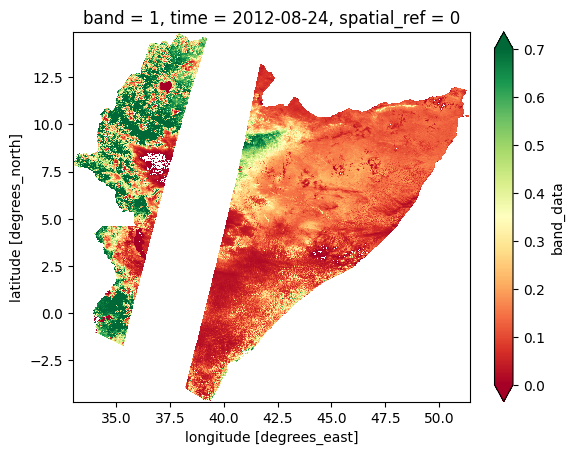

In [16]:
ds.band_data.isel(time=4).plot(vmin=0, vmax = 0.7, cmap="RdYlGn")

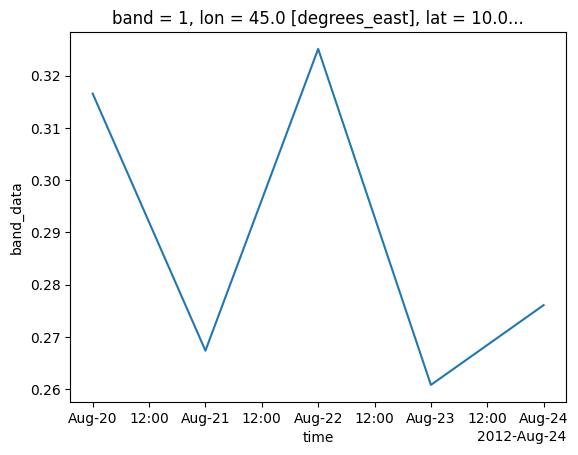

In [22]:
lat = 10
lon = 45

ds.band_data.sel(lat=lat, lon=lon, method="nearest").plot()